In [1]:
import cartopy
import cartopy.crs as ccrs
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap
from cartopy.util import add_cyclic_point; import cartopy.feature as cfeature
from scipy.interpolate import NearestNDInterpolator
import numpy as np
import pickle
import json
import xarray as xr
import os
import scipy.io
import shutil
import pandas as pd
from datetime import datetime, timedelta
import sys
sys.path.append(os.path.dirname(os.getcwd()))
from mpl_params import *
plt.rcParams.update(mpl_params(font_family='serif'))
import gcsfs
import re
import json
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from tqdm import tqdm

In [3]:
tk = os.path.join(os.path.dirname(os.path.dirname(os.getcwd())),'pangeo-181919-e7bc5bdaf4d5.json')
with open(tk) as f:
    token = json.load(f)
gcs = gcsfs.GCSFileSystem(token=token)

In [84]:
def plot_velocity_comparison(
    time, argo_u, M_u, argo_v=None, M_v=None,
    argo_u_uncert=None, M_u_uncert=None,
    argo_v_uncert=None, M_v_uncert=None,
    instrument_ind=None, M_depth=None, a_depth=None,
    lat=None, lon=None, save_path='',
    extra_title_str='',
):
    """
    Plots Argo vs Mooring velocity monthly means with uncertainty error bars.
    """

    from matplotlib.lines import Line2D
    import matplotlib.pyplot as plt

    fig, axs = plt.subplots(
        2 if argo_v is not None else 1, 1,
        figsize=(12, 6 if argo_v is not None else 4),
        sharex=True
    )
    if argo_v is None:
        axs = [axs]

    # print(time.shape, argo_u.shape, argo_u_uncert.shape)
    axs[0].grid(True)
    # Plot u-component with uncertainty + dashed line connections
    axs[0].plot(time, argo_u, color='blue', linestyle='--', linewidth=1, alpha=0.7)
    axs[0].plot(time, M_u, color='red', linestyle='--', linewidth=1, alpha=0.7)
    axs[0].errorbar(
        x=time, y=argo_u, yerr=argo_u_uncert, fmt='o',
        label='Argo u', color='blue', capsize=3
    )
    axs[0].errorbar(
        x=time, y=M_u, yerr=M_u_uncert, fmt='s',
        label='Mooring u', color='red', capsize=3
    )

    # Plot v-component if provided + dashed lines
    if argo_v is not None and M_v is not None:
        axs[1].plot(time, argo_v, color='green', linestyle='--', linewidth=1, alpha=0.7)
        axs[1].plot(time, M_v, color='orange', linestyle='--', linewidth=1, alpha=0.7)
        axs[1].errorbar(
            x=time, y=argo_v, yerr=argo_v_uncert, fmt='o',
            label='Argo v', color='green', capsize=3
        )
        axs[1].errorbar(
            x=time, y=M_v, yerr=M_v_uncert, fmt='s',
            label='Mooring v', color='orange', capsize=3
        )
        axs[1].set_ylabel("Meridional Velocity (v) [m/s]")
        axs[1].legend(loc='upper right')
        axs[1].grid(True)

    # Title info
    title = f"Instrument index {instrument_ind}" if instrument_ind is not None else "Velocity Monthly Means"
    if M_depth is not None and a_depth is not None:
        title += f"; Mooring Depth {int(M_depth)} m; Argo Depth {int(a_depth)} m"
    if lat is not None and lon is not None:
        title += f"; Lat: {lat:.2f}, Lon: {lon:.2f}\n"
    title += f"({str(time.min().date())} - {str(time.max().date())}) "
    title += extra_title_str
    axs[0].set_title(title); axs[0].legend(loc='upper right')
    axs[-1].set_xlabel("Time")
    axs[0].set_ylabel("Zonal Velocity (u) [m/s]")
    plt.tight_layout()
    axs[0].set_facecolor('white'); fig.patch.set_facecolor('white'); axs[-1].set_facecolor('white')
    if save_path:
        plt.savefig(save_path)
        plt.close()
    else:
        plt.show()


def plot_velocity_comparison_single_direction(
    time, argo_vel, M_vel, argo_vel_uncert=None, M_vel_uncert=None,
    instrument_ind=None, M_depth=None, a_depth=None,
    lat=None, lon=None, save_path='',
    extra_title_str='', direction='Zonal'
):
    """
    Plots Argo vs Mooring velocity monthly means with uncertainty error bars for one irection of velocity
    """

    from matplotlib.lines import Line2D
    import matplotlib.pyplot as plt

    fig, axs = plt.subplots(
        1, 1,
        figsize=(12, 4),
        sharex=True
    )
    # print(time.shape, argo_u.shape, argo_u_uncert.shape)
    axs.grid(True)
    # Plot u-component with uncertainty + dashed line connections
    axs.plot(time, argo_vel, color='blue', linestyle='--', linewidth=1, alpha=0.7)
    axs.plot(time, M_vel, color='red', linestyle='--', linewidth=1, alpha=0.7)
    axs.errorbar(
        x=time, y=argo_vel, yerr=argo_vel_uncert, fmt='o',
        label='Argo ' + direction.lower() + ' velocity', color='blue', capsize=3
    )
    axs.errorbar(
        x=time, y=M_vel, yerr=M_vel_uncert, fmt='s',
        label='Mooring ' + direction.lower() + ' velocity', color='red', capsize=3
    )

    # Title info
    title = "Velocity Monthly Means"
    if M_depth is not None and a_depth is not None:
        title += f"; Mooring Depth {int(M_depth)} m; Argo Depth {int(a_depth)} m"
    if lat is not None and lon is not None:
        title += f"; Lat: {lat:.2f}, Lon: {lon:.2f}\n"
    title += f"({str(time.min().date())} - {str(time.max().date())}) "
    title += extra_title_str
    axs[0].set_title(title); axs[0].legend(loc='upper right')
    axs[-1].set_xlabel("Time")
    axs[0].set_ylabel("Zonal Velocity (u) [m/s]")
    plt.tight_layout()
    if save_path:
        plt.savefig(save_path)
        plt.close()
    else:
        plt.show()

In [63]:
def get_month_list(start_date, end_date):
        return [(d.year, d.month) for d in pd.date_range(start=start_date, end=end_date, freq='MS')]

def temporal_processing(time, array, months, is_M=False, mses=None, deg_of_freedom=1, increment_min=None, window_days=10,):
    """
    Processes time series data to compute monthly means and uncertainties.

    Parameters:
    - time: array-like of datetime objects
    - array: array-like of data values corresponding to time
    - months: list of (year, month) tuples to extract
    - is_M: bool, whether the data is from moorings (True) or Argo (False)
    - mses: array-like of MSE values for Argo data (required if is_M=False)
    - window_days: number of days for mooring rolling mean
    - increment_min: time resolution (minutes) of mooring data (required if is_M=True)

    Returns:
    - means: list of monthly means
    - uncerts: list of uncertainties (std for moorings, sqrt(mean(mse)) for Argo)
    """
    if is_M:
        if increment_min is None:
            raise ValueError("increment_min must be provided for mooring data.")
        # Compute rolling window size in data points
        winsize = round(window_days / (increment_min / (60 * 24)))  # convert to samples
        array = pd.Series(array).rolling(winsize, 
                                         min_periods=1, # Minimum number of observations in window required to have a value; otherwise, result is np.nan.
                                         center=True # If True, set the window labels as the center of the window index.
                                         ).mean().to_numpy()

    time = pd.to_datetime(time)  # ensure datetime array
    means = []
    uncerts = []

    # go through months during overlap period to calculate means and uncerts
    for year, month in months:
        mask = (time.year == year) & (time.month == month)
        subset = array[mask]

        if len(subset) == 0 or np.all(np.isnan(subset)):
            means.append(np.nan)
            uncerts.append(np.nan)
            continue

        mean = np.nanmean(subset)

        if is_M:
            # Calculate the standard deviation of the mooring subset to gauge uncert
            uncert = np.nanstd(subset)
        else:
            # Using argo product MSEs, calculate standard error via the sum of the MSEs ()
            if mses is None:
                raise ValueError("MSEs must be provided for Argo data.")
            subset_mses = mses[mask]
            if len(subset_mses) == 0 or np.all(np.isnan(subset_mses)):
                uncert = np.nan
            else:
                # # uncert = np.sqrt(np.nanmean(subset_mses))
                u_valid_counts = np.count_nonzero(~np.isnan(subset_mses))  # count of non-NaN entries
                uncert =  np.sqrt(np.nansum(subset_mses) / u_valid_counts**2 * deg_of_freedom)

        means.append(mean)
        uncerts.append(uncert)

    return np.array(means), np.array(uncerts)

In [83]:
def deg_of_freedom_zeroDx(thetat, delta_t=10, flag=3):
    """
    Computes a covariance between two data points using a Matern 3/2 kernel.
    
    Parameters:
    - delta_t: scalar (time difference) in days
    - thetat: ndarray (decorrelation time scale) in days
    - flag: 1 or 2 (formula selector)
    
    Returns:
    - f: ndarray of correction factors
    """
    x = (delta_t / thetat)**2
    # distSpaceTime = np.sqrt(3 * x)
    # r = np.exp(-distSpaceTime)  # Matern function with nu = 1/2

    distSpaceTime = np.sqrt(x)
    coeff = (1 + np.sqrt(7) * distSpaceTime + 14/5*distSpaceTime**2 + 7*np.sqrt(7)/15*distSpaceTime**3) 
    r = coeff * np.exp(-np.sqrt(7) * distSpaceTime)  # Matern function with nu = 7/2. r represents the correlation between the two points
    # print('value of r:', r)

    if flag == 1: # for large n, order 1 effective sample size
        f = (1 + r) / (1 - r)
    elif flag == 2: # order 2 effective sample size for higher moment (not using here when just calculating standard error)
        f = (1 + r**2) / (1 - r**2)
    elif flag == 3: # for n=3 based on Jones 1975 small sample size equation 2.14
        f = 1 + 4/3 * r + 2/3 * r**2
    else:
        print("Select flag = 1 or 2")
        f = np.full_like(thetat, np.nan)
    return f


In [64]:
def matlab_datenum_to_datetime(dn):
    # see stackoverflow for source of this conversioin
    # https://stackoverflow.com/questions/13965740/converting-matlabs-datenum-format-to-python/13965852#13965852
    return datetime.fromordinal(int(dn)) + timedelta(days=dn % 1) - timedelta(days=366)
# root_directory = os.path.join(os.getcwd(), 'GMACMD_ArgoEKEmoorings')
# mat_file_paths = find_files(root_directory)
# print(mat_file_paths[0])

In [65]:
def plot_results(results):
    num_matches= results["num_matches"]
    M_time_freq = results["M_time_freq"]
    period_of_matching_data = results["period_of_matching_data"]

    # Convert frequencies and periods to arrays
    freqs = np.array(M_time_freq)
    periods = np.array(period_of_matching_data)

    fig, axs = plt.subplots(1, 2, figsize=(15, 5), constrained_layout=True)

    ### Plot 1: Histogram of mooring sampling frequencies
    axs[0].hist(freqs, bins=20, color='steelblue', edgecolor='black')
    axs[0].set_xlabel("Mooring Sampling Frequency (minutes)")
    axs[0].set_ylabel("Count")
    # # axs[0].set_title("Histogram of Mooring Sampling Frequencies")
    # axs[0].text(0.95, 0.95, f"Number of moored current meters whose\n timeseries overlap with Argo timespan: {num_matches}", 
    #             transform=axs[0].transAxes,
    #             ha='right', va='top', fontsize=10, bbox=dict(facecolor='white', edgecolor='black', boxstyle='round'))

    ### Plot 2: Matching time ranges
    for i, (start, end) in enumerate(periods):
        axs[1].hlines(y=i+1, xmin=start, xmax=end, color='darkred', linewidth=1.5)
        # axs[1].hlines(y=0, xmin=start, xmax=end, alpha=0.2, color='darkred', linewidth=1.5)

    axs[1].set_xlabel("Time")
    axs[1].set_ylabel("Mooring-Argo Match Index")
    axs[1].set_title("Periods of Mooring–Argo Time Series Overlap")
    axs[1].xaxis.set_major_locator(mdates.YearLocator(2))
    axs[1].xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
    axs[1].grid(True)

    plt.show()

In [66]:
# Make a feather plot using matplotlib's quiver which plots the time series as lines with magnitude and direction, anchored to the x-axis    
def plot_feather_quiver(
    time, argo_u, argo_v, M_u, M_v,
    instrument_ind=None, M_depth=None, a_depth=None,
    lat=None, lon=None, save_path='',
    extra_title_str=''
):
    """
    Plots feather/quiver plots for Argo and Mooring velocity data.

    Parameters:
    - time: datetime array (monthly time stamps)
    - argo_u, argo_v: Argo velocity components
    - M_u, M_v: Mooring velocity components
    """
    fig, ax = plt.subplots(figsize=(14, 4))
    ax.grid(True, alpha=0.25, zorder=0)

    # Create quiver anchor positions array
    time_numeric = np.arange(len(time))

    # Offset the arrows slightly vertically so Argo and Mooring are not on top of each other
    offset = 0
    zeros = np.zeros_like(time_numeric)

    max_v = np.nanmax(np.abs(np.concatenate([argo_v, M_v])))
    ax.set_ylim(-max_v * 1.1, max_v * 1.1)

    # Plot Mooring quivers
    ax.quiver(
        time_numeric, (zeros - offset), M_u, M_v, angles='uv',
        scale_units='y', scale=1, color='red', width=0.003, label='Mooring', 
        headlength=0, headwidth=0,
        alpha=0.8,
    )

    # Plot Argo quivers
    ax.quiver(
        time_numeric, (zeros + offset), argo_u, argo_v, angles='uv',
        scale_units='y', scale=1, color='blue', width=0.003, label='Argo', 
        headlength=0, headwidth=0,
        alpha=0.8,
    )

    # # Formatting
    ax.set_xticks(time_numeric)
    ax.set_xticklabels([t.strftime('%Y-%m') for t in time], rotation=45, ha='right')
    ax.set_xlim(-1.25, len(time)+0.25)  # margin for arrows
    ax.set_title(f"Instrument {instrument_ind}; Mooring Depth {int(M_depth)}m; Argo Depth {int(a_depth)}m\n"
                 f"Lat: {lat:.2f}, Lon: {lon:.2f} {extra_title_str}")
    ax.legend()
    ax.set_xlabel("Time")
    ax.set_ylabel("Velocity (m/s)")

    plt.tight_layout()
    if save_path:
        plt.savefig(save_path)
        plt.close()
    else:
        plt.show()


In [78]:
gcs.ls("pangeo-argo-eke/data/DynamicHeightData/")

['pangeo-argo-eke/data/DynamicHeightData/global_DH_20231005_chunked.zarr',
 'pangeo-argo-eke/data/DynamicHeightData/global_dynamic_height_chunked.zarr']

In [ ]:
DH = xr.open_zarr(
        gcs.get_mapper("pangeo-argo-eke/data/DynamicHeightData/global_DH_20231005_chunked.zarr"),
        consolidated=True
    )
DH_LAT = DH.LAT.values
DH_LON = DH.LON.values
DH_DATENUM = DH.DATENUM.values

In [ ]:
from numpy import pi, sin, cos, arccos, clip, deg2rad, arcsin, sqrt, arctan2, tan
# approximate radius of Earth in m
R_earth = 6.371e6

def distance(lat1, lat2, lon1, lon2):
    # CALCULATE HAVERSINE DISTANCE
    phi1, lambda1, phi2, lambda2 = deg2rad(lat1), deg2rad(lon1), deg2rad(lat2), deg2rad(lon2)
    
    a = sin((phi2 - phi1)/2)**2 + cos(phi1) * cos(phi2) * sin((lambda1 - lambda2)/2)**2 

    distance = R_earth * 2 * arcsin(sqrt(a))
    return distance # m


def count_num_profiles(mooring_lat, mooring_lon, min_t, max_t):
    # COUNT NUMBER OF ARGO PROFILES (DH PROFILES) AROUND THIS MOORING LOC AND within the temporal bounds
    count=0

    for ind, (alat, alon) in enumerate(zip(dh_LAT, dh_LON)):

        if distance(alat, mooring_lat, alon, mooring_lon) <= 500e3: #m
            dt = matlab_datenum_to_datetime(dh_DATENUM[ind])
            if dt >= min_t and dt <= max_t:
                count+=1

    return count

OOI Moorings
1. Global Argentine Basin
- Flanking Subsurface Mooring B
-42.496, -42.1255
- Flanking Subsurface Mooring A
-42.4921, -42.8802
- Apex Surface Mooring
-42.9204, -42.4409
- Apex Profiler mooring
-42.9781, -42.4957

03/15/2015 - 01/19/2018

2. Papa
- Apex Profiler mooring
50.0796, -144.806

- Flanking Subsurface Mooring A
49.9743, -144.24

- Flanking Subsurface Mooring B
50.3293, -144.398

07/2013-03/2016 for Apex; Flanking A also have 07/2017-present; Flanking B covers this whole period nonstop (may be the best to compare to!)

3. Southern Ocean
- Flanking Subsurface Mooring B
-54.0803, -88.9318

- Flanking Subsurface Mooring A
-54.1042, -89.6542

- Apex Surface Mooring
-54.4076, -89.3567

- Apex Profiler mooring
-54.4693, -89.3191

11/2015 - 12/2018 for Flanking A
02/2015- 12/2018 for Flanking B

4. Irmminger Sea.

- Flanking Subsurface Mooring B
59.7155, -39.3148

- Flanking Subsurface Mooring A
59.8177, -39.8412

- Apex Surface Mooring
59.9341, -39.4673

- Apex Profiler mooring
59.9695, -39.4886

09/2014 - present for flanking A/B
09/2014 - 03/2023 for apex surface
08/2015-present (with gaps) for apex profiler

In [47]:
lat_lon_pairs = [
    # 1. Global Argentine Basin
    (-42.496, -42.1255),  # Flanking Subsurface Mooring B
    (-42.4921, -42.8802), # Flanking Subsurface Mooring A
    (-42.9204, -42.4409), # Apex Surface Mooring
    (-42.9781, -42.4957), # Apex Profiler mooring

    # 2. Global Station Papa
    (50.0796, -144.806),  # Apex Profiler mooring
    (49.9743, -144.24),   # Flanking Subsurface Mooring A
    (50.3293, -144.398),  # Flanking Subsurface Mooring B

    # 3. Global Southern Ocean
    (-54.0803, -88.9318), # Flanking Subsurface Mooring B
    (-54.1042, -89.6542), # Flanking Subsurface Mooring A
    (-54.4076, -89.3567), # Apex Surface Mooring
    (-54.4693, -89.3191), # Apex Profiler mooring

    # 4. Global Irminger Sea
    (59.7155, -39.3148),  # Flanking Subsurface Mooring B
    (59.8177, -39.8412),  # Flanking Subsurface Mooring A
    (59.9341, -39.4673),  # Apex Surface Mooring
    (59.9695, -39.4886),  # Apex Profiler mooring
]

selected_OOI = [
    # 3. Global Southern Ocean
    # (-54.0803, -88.9318), # Flanking Subsurface Mooring B
    # (-54.1042, -89.6542), # Flanking Subsurface Mooring A
    (-54.4076, -89.3567), # Apex Surface Mooring

    # 4. Global Irminger Sea
    (59.7155, -39.3148),  # Flanking Subsurface Mooring B
    # (59.9341, -39.4673),  # Apex Surface Mooring

    # 2. Global Station Papa
    (50.3293, -144.398),  # Flanking Subsurface Mooring B

     # 1. Global Argentine Basin
    (-42.9781, -42.4957), # Apex Profiler mooring
]

selected_OOI_name_lat_lon = {
    # key : Sea and mooring name
    # value : (lat,lon)
    "Global Southern Ocean: Apex Surface Mooring": (-54.4076, -89.3567),
    "Global Irminger Sea: Flanking Subsurface Mooring B": (59.7155, -39.3148),
    "Global Station Papa: Flanking Subsurface Mooring B": (50.3293, -144.398),
    "Global Argentine Basin: Apex Profiler Mooring": (-42.9781, -42.4957),
}


In [38]:
# AGVA MAPPED TO OOI MOORINGS
mapped_agva = xr.open_zarr(
        gcs.get_mapper('pangeo-argo-eke/mooringlocation_mapped_EKE/OOIMoorings_EstimatedCovParams.zarr'),
        consolidated=True
    )
argo_plevels = mapped_agva.pressure.values
mapped_agva



<xarray.Dataset> Size: 12MB
Dimensions:                (mooringlocation_index: 15, time: 657, pressure: 30,
                            latitude: 15, longitude: 15, parameter: 6)
Coordinates:
  * latitude               (latitude) float64 120B -42.5 -42.49 ... 59.93 59.97
  * longitude              (longitude) float64 120B -42.13 -42.88 ... -39.49
  * mooringlocation_index  (mooringlocation_index) int64 120B 0 1 2 ... 12 13 14
  * parameter              (parameter) int64 48B 0 1 2 3 4 5
  * pressure               (pressure) float64 240B 0.0 5.0 ... 1.9e+03 2e+03
  * time                   (time) datetime64[ns] 5kB 2004-01-06 ... 2021-12-22
Data variables:
    EKE                    (mooringlocation_index, time, pressure) float64 2MB dask.array<chunksize=(1, 657, 30), meta=np.ndarray>
    opt_covparams          (mooringlocation_index, pressure, parameter) float64 22kB dask.array<chunksize=(1, 30, 6), meta=np.ndarray>
    u                      (mooringlocation_index, time, pressure) float64 2MB dask.array<chunksize=(1, 657, 30), meta=np.ndarray>
    uMSE                   (mooringlocation_index, time, pressure) float64 2MB dask.array<chunksize=(1, 657, 30), meta=np.ndarray>
    v                      (mooringlocation_index, time, pressure) float64 2MB dask.array<chunksize=(1, 657, 30), meta=np.ndarray>
    vMSE                   (mooringlocation_index, time, pressure) float64 2MB dask.array<chunksize=(1, 657, 30), meta=np.ndarray>
Attributes:
    betaparamfile:               pangeo-argo-eke/testfolder_112/vel_betaparams/
    description:                 Estimated velocities & uncertainties, mapped...
    filename:                    pangeo-argo-eke/mooringlocation_mapped_EKE/O...
    initialized_date:            2025-08-10 12:01:33.177329
    number_of_harmonics:         2
    residualfile:                pangeo-argo-eke/testfolder_112/vel_argolocat...
    uvfitfile:                   pangeo-argo-eke/testfolder_112/global_uvfit_...
    window_size_betaparameters:  500000.0

In [55]:
def compare_OOI_argo(
    mapped_agva, argo_plevels, dirroot, 
    plot_dir="plots", days_to_smooth_mooring=10, loop_step=1, extra_title_str=''
):
    # loop through OOI data files in ooi_mooring_data/
    for ooi_file_ind in range(len(os.listdir(os.path.join(dirroot, "ooi_mooring_data")))):
        ooi_file = os.listdir(os.path.join(dirroot, "ooi_mooring_data"))[ooi_file_ind]
        # Load OOI data
        OOI_data = xr.open_dataset(os.path.join(dirroot, "ooi_mooring_data", ooi_file))
        platform_name = OOI_data.platform_name; print(platform_name)
        # Get the data variables
        M_depth = OOI_data["z"]
        M_ind = OOI_data.attrs["station_id"]
        M_time = OOI_data["time"]
        # get the increment from the M_time array
        M_time_increment = np.diff(M_time.values).astype('timedelta64[s]').astype(float)
        
        # Check if the  increments are uniform
        if not np.allclose(M_time_increment, M_time_increment[0]):
            print(f"Warning: Non-uniform time increments found in {platform_name}")
            continue
            # print('Going to average increment')
            # M_time_increment = np.mean(M_time_increment)
        else:
            M_time_increment = M_time_increment[0]
        print('increment:', M_time_increment)

        # Get the lat lon from selected_OOI_name_lat_lon
        for name in selected_OOI_name_lat_lon.keys():
            # split the platform name by :
            platform_name_subset = platform_name.split(":")
            for subset in platform_name_subset:
                if subset in name:
                    lat_lon = selected_OOI_name_lat_lon[name]
                    print(f"Found lat lon for {platform_name}: {lat_lon}")
                break

        # Continue with the rest of the function logic
        curr_M_lat, curr_M_lon = lat_lon
        
        begintime = matlab_datenum_to_datetime(M_time.values[0])
        endtime = matlab_datenum_to_datetime(M_time.values[-1])

        plevel_ind = np.abs(argo_plevels - M_depth).argmin()
        curr_argo_tseries = mapped_agva.isel(
            pressure=plevel_ind).sel(
            latitude=curr_M_lat,
            longitude=curr_M_lon,
        )
        argo_u, argo_v = curr_argo_tseries.u, curr_argo_tseries.v
        argo_time = pd.to_datetime(curr_argo_tseries.time.values)

        ### Trim the mooring time series to be within 2004-2021 (argo time min and time max)
        M_time = pd.to_datetime(M_time)

        argo_start, argo_end = argo_time.min(), argo_time.max()
        overlap_start, overlap_end = max(begintime, argo_start), min(endtime, argo_end)
        overlap_days = (overlap_end - overlap_start).days
        if overlap_days <= 0 or overlap_days < 100:
            continue

        # Get the months within the overlap period for calculating the mean
        months = get_month_list(overlap_start, overlap_end)

        OOI_data_vars = OOI_data.data_vars
        if "eastward_sea_water_velocity" in OOI_data_vars:
            M_u = OOI_data["eastward_sea_water_velocity"]
            M_u_means, M_u_uncert = temporal_processing(M_time, M_u, months,is_M=True, window_days=days_to_smooth_mooring, increment_min=M_time_increment)
            argo_u_mses = curr_argo_tseries.uMSE
            argo_u_means, argo_u_uncert = temporal_processing(argo_time, argo_u, months, is_M=False)
        if "northward_sea_water_velocity" in OOI_data_vars:
            M_v = OOI_data["northward_sea_water_velocity"]
            M_v_means, M_v_uncert = temporal_processing(M_time, M_v, months,is_M=True, window_days=days_to_smooth_mooring, increment_min=M_time_increment)
            argo_v_mses = curr_argo_tseries.vMSE
            argo_v_means, argo_v_uncert = temporal_processing(argo_time, argo_v, months, is_M=False)

        thetat = curr_argo_tseries.opt_covparams.isel(parameter=3)

        # if not (len(argo_u_means) == len(months) == len(M_u_means) == len(argo_v_means) == len(M_v_means)):
        #     print(f"Length mismatch at instrument {source_idx}")
        #     continue

        # Convert months list to a datetime array
        months_tuples = months
        months = pd.to_datetime([f"{y}-{m:02d}" for y, m in months])

        min_t = months.min(); max_t = months.max()
        print('min_t, max_t', min_t, max_t, 'type(min_t)', type(min_t))
        num_argo_profiles = count_num_profiles(curr_M_lat, curr_M_lon, min_t, max_t)
        print('Number of Argo profiles within 500km and during the mooring time period:', num_argo_profiles)

        # Make a plot of the time series
        if 'eastward_sea_water_velocity' in OOI_data_vars:
            plot_velocity_comparison_single_direction(
                time=months, argo_vel=argo_u_means, M_vel=M_u_means, 
                argo_vel_uncert=argo_u_uncert, M_vel_uncert=M_u_uncert,
                M_depth=M_depth, a_depth=argo_plevels[plevel_ind],
                lat=curr_M_lat, lon=curr_M_lon,
                save_path=os.path.join(plot_dir, f"OOI_{ooi_file_ind}_eastward_velocity.png"),
                direction='Zonal'
            )
            # plot_feather_quiver(
            #     time=months, argo_u=argo_u_means, M_u=M_u_means, 
            #     argo_v=argo_v_means, M_v=M_v_means,
            #     instrument_ind=source_idx, M_depth=depth, a_depth=argo_plevels[plevel_ind],
            #     lat=curr_M_lat,lon=curr_M_lon, 
            #     save_path=os.path.join(plot_dir, f"instrument_{source_idx}_{days_to_smooth_mooring}smoothing_feather_y.png"), 
            #     extra_title_str=extra_title_str,
            # )
        elif 'northward_sea_water_velocity' in OOI_data_vars:
            plot_velocity_comparison_single_direction(
                time=months, argo_vel=argo_v_means, M_vel=M_v_means, 
                argo_vel_uncert=argo_v_uncert, M_vel_uncert=M_v_uncert,
                M_depth=M_depth, a_depth=argo_plevels[plevel_ind],
                lat=curr_M_lat, lon=curr_M_lon,
                save_path=os.path.join(plot_dir, f"OOI_{ooi_file_ind}_northward_velocity.png"),
                direction='Meridional'
            )


compare_OOI_argo(mapped_agva, argo_plevels, os.getcwd())

Global Irminger Sea: Flanking Subsurface Mooring B: Mooring Riser: Single Point Velocity Meter (1800 meters)
Global Irminger Sea: Flanking Subsurface Mooring B: Mooring Riser: Single Point Velocity Meter (1800 meters)
Global Southern Ocean: Apex Surface Mooring: Near Surface Instrument Frame: Single Point Velocity Meter
Global Southern Ocean: Apex Surface Mooring: Near Surface Instrument Frame: Single Point Velocity Meter


In [11]:
def plot_raw_velocities_on_axes(ds, axes, label_suffix=""):
    """
    data_dict = {
                    'time': time,
                    'z': depth,
                    'velocity': velocity,
                    'direction': vel_dir
                }
    """
    time = ds['time']
    depth = ds['z']

    # Northward velocity
    if ds['direction'] == 'northward':
        sc1 = axes[0].scatter(
            time, depth,
            c=ds['velocity'],
            s=5, cmap='coolwarm'
        )
        axes[0].invert_yaxis()
        axes[0].set_title(f"Northward Velocity {label_suffix} (m/s)")
        plt.colorbar(sc1, ax=axes[0], label='m/s')

    # Eastward velocity
    if ds['direction'] == 'eastward':
        sc3 = axes[1].scatter(
            time, depth,
            c=ds['velocity'],
            s=5, cmap='coolwarm'
        )
        axes[1].invert_yaxis()
        axes[1].set_title(f"Eastward Velocity {label_suffix} (m/s)")
        plt.colorbar(sc3, ax=axes[1], label='m/s')

    # Labels
    for ax in axes.flat:
        ax.set_ylabel("Depth (m)")
    axes[1].set_xlabel("Time")
    axes[1].set_xlabel("Time")


Do the comparison with the 'Global Irminger Sea: Flanking Subsurface Mooring B' mooring data

In [32]:
data = OOI_data['Global Irminger Sea: Flanking Subsurface Mooring B']
mooring_time = data[0]['time'] # datetime array
mooring_depth = data[0]['z'] # depth array
u_drift = data[0]['velocity'] # zonal velocity array
v_drift = data[1]['velocity'] # meridional velocity array
print(type(mooring_depth))

<class 'float'>


In [30]:
# Select AGVA mapped at this mooring's location
# (59.7155, -39.3148),  # Irminger Sea: Flanking Subsurface Mooring B
mapped_agva_loc = mapped_agva.sel(
    latitude=59.7155,
    longitude=-39.3148,
    pressure=mooring_depth,
)
mapped_agva_loc 

<xarray.Dataset> Size: 400kB
Dimensions:                (mooringlocation_index: 15, time: 657, parameter: 6)
Coordinates:
    latitude               float64 8B 59.72
    longitude              float64 8B -39.31
  * mooringlocation_index  (mooringlocation_index) int64 120B 0 1 2 ... 12 13 14
  * parameter              (parameter) int64 48B 0 1 2 3 4 5
    pressure               float64 8B 1.8e+03
  * time                   (time) datetime64[ns] 5kB 2004-01-06 ... 2021-12-22
Data variables:
    EKE                    (mooringlocation_index, time) float64 79kB dask.array<chunksize=(1, 657), meta=np.ndarray>
    opt_covparams          (mooringlocation_index, parameter) float64 720B dask.array<chunksize=(1, 6), meta=np.ndarray>
    u                      (mooringlocation_index, time) float64 79kB dask.array<chunksize=(1, 657), meta=np.ndarray>
    uMSE                   (mooringlocation_index, time) float64 79kB dask.array<chunksize=(1, 657), meta=np.ndarray>
    v                      (mooringlocation_index, time) float64 79kB dask.array<chunksize=(1, 657), meta=np.ndarray>
    vMSE                   (mooringlocation_index, time) float64 79kB dask.array<chunksize=(1, 657), meta=np.ndarray>
Attributes:
    betaparamfile:               pangeo-argo-eke/testfolder_112/vel_betaparams/
    description:                 Estimated velocities & uncertainties, mapped...
    filename:                    pangeo-argo-eke/mooringlocation_mapped_EKE/O...
    initialized_date:            2025-08-10 12:01:33.177329
    number_of_harmonics:         2
    residualfile:                pangeo-argo-eke/testfolder_112/vel_argolocat...
    uvfitfile:                   pangeo-argo-eke/testfolder_112/global_uvfit_...
    window_size_betaparameters:  500000.0

In [ ]:
# # Open gmacmd mooring file at "ooi-ga02hypm-wfp02-05-vel3dl000_f0da_9576_b1f9.nc"
# mooring = xr.open_dataset(os.path.join(os.getcwd(), 'ooi-ga02hypm-wfp02-05-vel3dl000_f0da_9576_b1f9.nc'))
# mooring

<xarray.Dataset> Size: 73MB
Dimensions:                                                    (row: 2269403)
Dimensions without coordinates: row
Data variables:
    time                                                       (row) datetime64[ns] 18MB ...
    eastward_sea_water_velocity_profiler_depth_enabled         (row) float64 18MB ...
    eastward_sea_water_velocity_profiler_depth_enabled_qc_agg  (row) float64 18MB ...
    z                                                          (row) float64 18MB ...
Attributes: (12/44)
    cdm_altitude_proxy:            z
    cdm_data_type:                 TimeSeriesProfile
    cdm_profile_variables:         time
    cdm_timeseries_variables:      station,longitude,latitude
    contributor_email:             feedback@axiomdatascience.com
    contributor_name:              Axiom Data Science
    ...                            ...
    standard_name_vocabulary:      CF Standard Name Table v72
    station_id:                    104017
    summary:                       Timeseries data from 'Global Argentine Bas...
    time_coverage_end:             2017-10-03T18:00:00Z
    time_coverage_start:           2015-03-17T00:00:00Z
    title:                         Global Argentine Basin: Apex Profiler Moor...

In [56]:
gmacmdroot = 'c:\\Users\\annab\\Desktop\\ArgoEKE\\aies-argo\\MooringData\\GMACMD_ArgoEKEmoorings\\GMACMD_ArgoEKEmoorings' #'/Users/cwortham/Documents/research/argo-eke/data/MooringData/GMACMD_ArgoEKEmoorings/'

# Load meta-data previously saved by find_useful_data_argoVSmooring.m
meta = scipy.io.loadmat('metaout_argoVSmooring.mat', squeeze_me=True)
for var in meta.keys():
    if not var.startswith('__'):
        if not type(meta[var]) == type(1):
            sh = meta[var].shape
            print(var, sh)
        else:
            print(var, meta[var])
        # print(sh)
        # if not sh==(7993,1):

M_instruments = meta['Mooring_instruments'] # (1620, 285)
M_Source_mat = meta['Source_mat'] #  (7993,)
M_Increment = meta['Increment'] # (7993,)
M_Depth = meta['Depth'] # (7993,)

# print(Source_mat[0])
# #initialize u and v arrays
# u_smooth = np.full_like(Mooring_instruments, np.nan, dtype=float)
# v_smooth = np.full_like(Mooring_instruments, np.nan, dtype=float)

Archive_name (7993,)
Array_name (7993,)
BeginDate (7993,)
BeginTime (7993,)
Depth (7993,)
Duration (7993,)
EndDate (7993,)
EndTime (7993,)
Increment (7993,)
Inst_mooring_name (7993,)
Inst_mooring_type (7993,)
Instrument_type (7993,)
Lat (7993,)
Lon (7993,)
Notes (7993,)
Original_data (7993,)
Principal_investigator (7993,)
QC_checks (7993, 5)
QC_def (26,)
QC_flag (7993, 26)
Reference (7993,)
Seafloor_depth (7993,)
Source_mat (7993,)
Var_def (21,)
Var_flag (7993, 21)
Mooring_depths (1620, 285)
Mooring_instruments (1620, 285)
Mooring_lat (1620,)
Mooring_lon (1620,)
Mooring_ninst (1620,)
Num_moorings 1620


In [57]:
#AGVA MAPPED TO GMACMD MOORINGS
mapped_agva = xr.open_zarr(
        gcs.get_mapper('pangeo-argo-eke/mooringlocation_mapped_EKE/AllMoorings_EstimatedCovParams.zarr'),
        consolidated=True
    )
argo_plevels = mapped_agva.pressure.values
mapped_agva

<xarray.Dataset> Size: 1GB
Dimensions:                (mooringlocation_index: 1620, time: 657,
                            pressure: 30, latitude: 1620, longitude: 1620,
                            parameter: 6)
Coordinates:
  * latitude               (latitude) float64 13kB 32.7 32.16 ... 39.58 38.11
  * longitude              (longitude) float64 13kB -128.1 -128.0 ... -9.968
  * mooringlocation_index  (mooringlocation_index) int64 13kB 0 1 ... 1618 1619
  * parameter              (parameter) int64 48B 0 1 2 3 4 5
  * pressure               (pressure) float64 240B 0.0 5.0 ... 1.9e+03 2e+03
  * time                   (time) datetime64[ns] 5kB 2004-01-06 ... 2021-12-22
Data variables:
    EKE                    (mooringlocation_index, time, pressure) float64 255MB dask.array<chunksize=(1, 657, 30), meta=np.ndarray>
    opt_covparams          (mooringlocation_index, pressure, parameter) float64 2MB dask.array<chunksize=(1, 30, 6), meta=np.ndarray>
    u                      (mooringlocation_index, time, pressure) float64 255MB dask.array<chunksize=(1, 657, 30), meta=np.ndarray>
    uMSE                   (mooringlocation_index, time, pressure) float64 255MB dask.array<chunksize=(1, 657, 30), meta=np.ndarray>
    v                      (mooringlocation_index, time, pressure) float64 255MB dask.array<chunksize=(1, 657, 30), meta=np.ndarray>
    vMSE                   (mooringlocation_index, time, pressure) float64 255MB dask.array<chunksize=(1, 657, 30), meta=np.ndarray>
Attributes:
    betaparamfile:               pangeo-argo-eke/testfolder_112/vel_betaparams/
    description:                 Estimated velocities & uncertainties, mapped...
    filename:                    pangeo-argo-eke/mooringlocation_mapped_EKE/A...
    initialized_date:            2025-04-21 18:21:08.932056
    number_of_harmonics:         2
    residualfile:                pangeo-argo-eke/testfolder_112/vel_argolocat...
    uvfitfile:                   pangeo-argo-eke/testfolder_112/global_uvfit_...
    window_size_betaparameters:  500000.0

In [69]:
M_lat = meta['Mooring_lat']; M_lon = meta['Mooring_lon']
condition1 = M_lon > 180.0
condition2 = M_lon <= -180.0
M_lon[condition1] = M_lon[condition1] - 360.0
M_lon[condition2] = M_lon[condition2] + 360.0

In [80]:
plot_instr_inds = [4719,4707, 4728,4468,4477,5408,3321, 5422, 3363]
# plot_instr_inds = [4719, 5408,5422]
def process_mooring_argo_matches(
        M_instruments, M_Depth, M_Source_mat, M_Increment, M_lat, M_lon,
        mapped_agva, argo_plevels, gmacmdroot, start_index=0, plot_limit=15, 
        plot_dir="plots", days_to_smooth_mooring=10, loop_step=100, extra_title_str=''
    ):

    # Record data matching stats
    num_matches = 0 # number of mooring timeseries that have a matching argo timeseries
    M_time_freq = [] # frequencies of mooring data 
    period_of_matching_data = [] # length of overlapping timespans between the two datasets

    for ii in tqdm(range(start_index, M_instruments.size, loop_step)):
        ### Get indexes for this current meter instrument (mooring, meter) (1620, 285)
        I, J = np.unravel_index(ii, M_instruments.shape)
        # Skip empty elements of Mooring_instruments source index array
        if np.isnan(M_instruments[I, J]):
            continue

        # Get individual current meter index -- source_idx
        source_idx = int(M_instruments[I, J]) - 1 #adjust for matlab based indexing
        if not (source_idx in plot_instr_inds):
            continue
        depth = M_Depth[source_idx] # depth for individual current meter
        # Skip current meters deeper than 2000 m
        if depth>=2000: continue

        ### Load time series for this current meter
        filepath = os.path.join(gmacmdroot, M_Source_mat[source_idx])
        data = scipy.io.loadmat(filepath, squeeze_me=True)
        M_u, M_v = data['u'], data['v']
        # Skip instrument if less than 50% data coverage
        if np.sum(np.isnan(M_u + M_v)) > len(M_u) / 2:
            continue

        begintime = matlab_datenum_to_datetime(data['begintime'])
        endtime = matlab_datenum_to_datetime(data['endtime'])
        increment_min = M_Increment[source_idx]
        if np.isnan(increment_min):
            continue
        
        ### Use nearest neighbor to match the current meter depth to an argo plevel
        curr_M_lat, curr_M_lon = M_lat[I], M_lon[I]
        # curr_argo_lat = mapped_agva.latitude.values[I]
        # curr_argo_lon = mapped_agva.longitude.values[I]
        if curr_M_lat < 2 and curr_M_lat > -2: # don't look at profiles within 2 deg N/S of the equator
            continue

        plevel_ind = np.abs(argo_plevels - depth).argmin()
        curr_argo_tseries = mapped_agva.isel(
            pressure=plevel_ind,
            latitude=I,
            longitude=I,
            mooringlocation_index=I
        )
        argo_u, argo_v = curr_argo_tseries.u, curr_argo_tseries.v
        argo_time = pd.to_datetime(curr_argo_tseries.time.values)

        ### Trim the mooring time series to be within 2004-2021 (argo time min and time max)
        M_time = [begintime + pd.Timedelta(minutes=increment_min * i) for i in range(M_u.size)]
        M_time = pd.to_datetime(M_time)

        if abs((M_time[-1] - endtime).total_seconds()) > 300:
            print(f"Time mismatch for source {source_idx}: calculated endtime {M_time[-1]}, metadata endtime {endtime}") # sanity check that the calculated endtime is same as endtime in metadata

        argo_start, argo_end = argo_time.min(), argo_time.max()
        overlap_start, overlap_end = max(begintime, argo_start), min(endtime, argo_end)
        overlap_days = (overlap_end - overlap_start).days
        if overlap_days <= 0 or overlap_days < 100:
            continue

        # Get the months within the overlap period for calculating the mean
        months = get_month_list(overlap_start, overlap_end)
        M_u_means, M_u_uncert = temporal_processing(M_time, M_u, months,is_M=True, window_days=days_to_smooth_mooring, increment_min=increment_min)
        M_v_means, M_v_uncert = temporal_processing(M_time, M_v, months,is_M=True, window_days=days_to_smooth_mooring, increment_min=increment_min)
        argo_u_mses = curr_argo_tseries.uMSE; argo_v_mses = curr_argo_tseries.vMSE
        thetat = curr_argo_tseries.opt_covparams.isel(parameter=3)
        print('instrument',source_idx, 'thetat', thetat.values, 'df',deg_of_freedom_zeroDx(thetat).values)
        argo_u_means, argo_u_uncert = temporal_processing(argo_time, argo_u.values, months, is_M=False, mses=argo_u_mses, deg_of_freedom=deg_of_freedom_zeroDx(thetat))
        argo_v_means, argo_v_uncert = temporal_processing(argo_time, argo_v.values, months, is_M=False, mses = argo_v_mses, deg_of_freedom=deg_of_freedom_zeroDx(thetat))
       
        if not (len(argo_u_means) == len(months) == len(M_u_means) == len(argo_v_means) == len(M_v_means)):
            print(f"Length mismatch at instrument {source_idx}")
            continue

        # print('CKPT:', argo_u_trimmed.shape, mooring_u_smooth.shape)
        num_matches += 1
        M_time_freq.append(increment_min)
        period_of_matching_data.append((overlap_start, overlap_end))

        # Convert months list to a datetime array
        months_tuples = months
        months = pd.to_datetime([f"{y}-{m:02d}" for y, m in months])

        min_t = months.min(); max_t = months.max()
        print('min_t, max_t', min_t, max_t, 'type(min_t)', type(min_t))
        # num_argo_profiles = count_num_profiles(curr_M_lat, curr_M_lon, min_t, max_t)
        # print('Number of Argo profiles within 500km and during the mooring time period:', num_argo_profiles)

        # Make a plot of the two time series
        if (num_matches < plot_limit or months_tuples[-1][0] > 2008):
            plot_velocity_comparison(
                time=months, argo_u=argo_u_means, M_u=M_u_means, 
                argo_v=argo_v_means, M_v=M_v_means,
                argo_u_uncert=argo_u_uncert, M_u_uncert=M_u_uncert,
                argo_v_uncert=argo_v_uncert, M_v_uncert=M_v_uncert,
                instrument_ind=source_idx, M_depth=depth, a_depth=argo_plevels[plevel_ind],
                lat=curr_M_lat,lon=curr_M_lon, 
                save_path=os.path.join(plot_dir, f"instrument_{source_idx}_{days_to_smooth_mooring}smoothing_v2.png"), 
                extra_title_str=extra_title_str,
            )
            # plot_feather_quiver(
            #     time=months, argo_u=argo_u_means, M_u=M_u_means, 
            #     argo_v=argo_v_means, M_v=M_v_means,
            #     instrument_ind=source_idx, M_depth=depth, a_depth=argo_plevels[plevel_ind],
            #     lat=curr_M_lat,lon=curr_M_lon, 
            #     save_path=os.path.join(plot_dir, f"instrument_{source_idx}_{days_to_smooth_mooring}smoothing_feather_y.png"), 
            #     extra_title_str=extra_title_str,
            # )
    return {
        "num_matches": num_matches,
        "M_time_freq": M_time_freq,
        "period_of_matching_data": period_of_matching_data
    }


  0%|          | 0/83556 [00:00<?, ?it/s]

instrument 4707 thetat 22.34848342310246 df 2.6743999155408833


C:\Users\annab\AppData\Local\Temp\ipykernel_23928\862465439.py:94: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  months = pd.to_datetime([f"{y}-{m:02d}" for y, m in months])


min_t, max_t 2004-04-01 00:00:00 2005-05-01 00:00:00 type(min_t) <class 'pandas._libs.tslibs.timestamps.Timestamp'>


 12%|█▏        | 9685/83556 [01:00<07:40, 160.29it/s]

instrument 4719 thetat 23.060514129949585 df 2.691810849629899


 12%|█▏        | 9685/83556 [01:13<07:40, 160.29it/s]C:\Users\annab\AppData\Local\Temp\ipykernel_23928\862465439.py:94: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  months = pd.to_datetime([f"{y}-{m:02d}" for y, m in months])


min_t, max_t 2004-04-01 00:00:00 2005-05-01 00:00:00 type(min_t) <class 'pandas._libs.tslibs.timestamps.Timestamp'>


 12%|█▏        | 9686/83556 [01:31<13:14, 92.96it/s] 

instrument 5408 thetat 1036.2083084677392 df 2.9998261631028686


C:\Users\annab\AppData\Local\Temp\ipykernel_23928\862465439.py:94: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  months = pd.to_datetime([f"{y}-{m:02d}" for y, m in months])


min_t, max_t 2007-06-01 00:00:00 2008-05-01 00:00:00 type(min_t) <class 'pandas._libs.tslibs.timestamps.Timestamp'>


 47%|████▋     | 39566/83556 [01:56<01:13, 598.39it/s]

instrument 3363 thetat 18.03681529005296 df 2.531956620681669


 47%|████▋     | 39566/83556 [02:13<01:13, 598.39it/s]

min_t, max_t 2010-08-01 00:00:00 2011-04-01 00:00:00 type(min_t) <class 'pandas._libs.tslibs.timestamps.Timestamp'>


 54%|█████▍    | 45490/83556 [02:16<01:16, 495.91it/s]

instrument 3321 thetat 17.611295079709045 df 2.513408968905738


 54%|█████▍    | 45490/83556 [02:33<01:16, 495.91it/s]

min_t, max_t 2007-07-01 00:00:00 2008-06-01 00:00:00 type(min_t) <class 'pandas._libs.tslibs.timestamps.Timestamp'>


 54%|█████▍    | 45538/83556 [02:39<02:00, 315.92it/s]

instrument 4468 thetat 21.496758601151903 df 2.651668764118276


C:\Users\annab\AppData\Local\Temp\ipykernel_23928\862465439.py:94: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  months = pd.to_datetime([f"{y}-{m:02d}" for y, m in months])


min_t, max_t 2005-06-01 00:00:00 2006-10-01 00:00:00 type(min_t) <class 'pandas._libs.tslibs.timestamps.Timestamp'>


 68%|██████▊   | 56882/83556 [03:23<01:32, 288.67it/s]

instrument 4477 thetat 22.66251930385469 df 2.6822479603875675


 68%|██████▊   | 56882/83556 [03:33<01:32, 288.67it/s]C:\Users\annab\AppData\Local\Temp\ipykernel_23928\862465439.py:94: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  months = pd.to_datetime([f"{y}-{m:02d}" for y, m in months])


min_t, max_t 2006-11-01 00:00:00 2008-04-01 00:00:00 type(min_t) <class 'pandas._libs.tslibs.timestamps.Timestamp'>


 68%|██████▊   | 56883/83556 [04:15<02:51, 155.92it/s]

instrument 4728 thetat 22.966193342222876 df 2.689582189019036


C:\Users\annab\AppData\Local\Temp\ipykernel_23928\862465439.py:94: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  months = pd.to_datetime([f"{y}-{m:02d}" for y, m in months])


min_t, max_t 2005-06-01 00:00:00 2005-11-01 00:00:00 type(min_t) <class 'pandas._libs.tslibs.timestamps.Timestamp'>


 69%|██████▉   | 57850/83556 [04:29<03:00, 142.45it/s]

instrument 5422 thetat 1066.7636700879987 df 2.9998359782655912


 69%|██████▉   | 57850/83556 [04:43<03:00, 142.45it/s]C:\Users\annab\AppData\Local\Temp\ipykernel_23928\862465439.py:94: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  months = pd.to_datetime([f"{y}-{m:02d}" for y, m in months])


min_t, max_t 2009-06-01 00:00:00 2010-05-01 00:00:00 type(min_t) <class 'pandas._libs.tslibs.timestamps.Timestamp'>


100%|██████████| 83556/83556 [04:52<00:00, 286.04it/s]


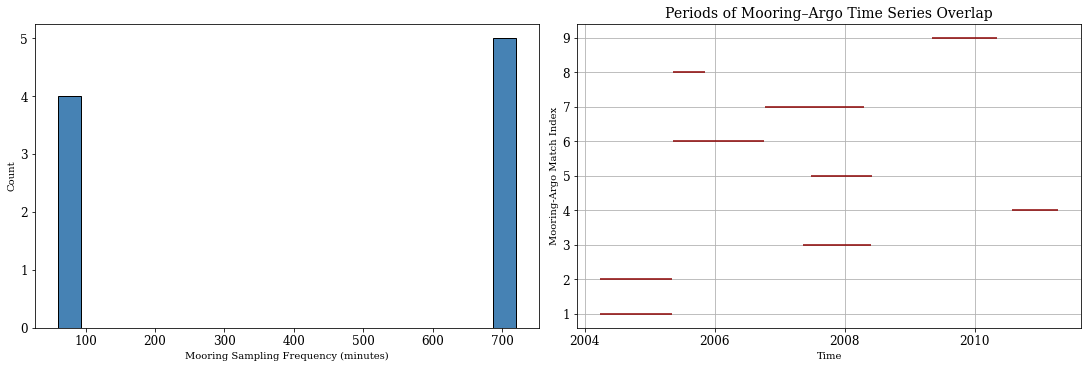

In [85]:
results_10daysmoothing = process_mooring_argo_matches(
    M_instruments=M_instruments,
    M_Depth=M_Depth,
    M_Source_mat=M_Source_mat,
    M_Increment=M_Increment,
    M_lat=M_lat,
    M_lon=M_lon,
    mapped_agva=mapped_agva,
    argo_plevels=argo_plevels,
    gmacmdroot=gmacmdroot,
    start_index=43923,  # or 0 to analyze more
    plot_limit=200,
    plot_dir="plots",
    days_to_smooth_mooring=10,
    loop_step=5, # REDUCE TO ANALYZE MORE
    extra_title_str = ''
)

plot_results(results_10daysmoothing)